# _Notebook 0: Introduction to `Dask` for Climate Science Data Analysis_
Part 0/3 of the [ETH Zurich UP](https://up.ethz.ch) Dask Workshop \
_Aaron Wienkers, 2024_

**Objectives of this Notebook**:
1. Understand the fundamentals of task-based parallelism and `dask` 
2. Introduce the two main concepts in `dask`: _workers_ & _chunks_ 
3. Learn how to install and set up `dask` 
4. Demonstrate how to create, manipulate, and destroy `dask` arrays 

N.B.: This workshop will focus on the `xarray` wrapper for `dask`; however, many of the ideas presented are widely applicable to the raw `dask` data structures (if not more cumbersome without `xarray`).

<small>
N.N.B.: These examples were designed to run on a DKRZ `Levante` Compute Node with 128 cores and 256 GB memory. The file paths therefore also refer to the scratch drive at DKRZ. Nonetheless, an inherent strength of `dask` is its interoperability with different computing architectures; however, these examples should then be modified to account for the specifications of your own system. In this case, please find the data on the ETH `sea`/`kryo` servers at `/work/awienkers/dask_example_scratch`, or reach out to me for access to the example datasets.
</small>

---

## Task-Based Parallelism & `dask`

- Task-based parallelism is a programming paradigm that focuses on decomposing a problem into smaller, independent tasks that can be executed concurrently. 
- Dependencies between tasks must be specified and are represented in a _task graph_. 
- The graph is then iteratively traversed to determine which tasks are currently able to be executed. These tasks are then sent to a pool of workers for computation.

Here is an example such graph:
![\[https://hpc2n.github.io/Task-based-parallelism/branch/master/_images/lu_task_graph3.png\]](https://hpc2n.github.io/Task-based-parallelism/branch/master/_images/lu_task_graph3.png)


- Luckily, `dask` makes task-based parallelism easy ! *
- `Dask` 
    - ...is a powerful Python library which is deeply integrated into `xarray`, `numpy`, ... meaning that often it "just works" ().
    - ...is a _data-oriented_ task-based parallel framework which generates tasks by dividing data into "chunks". 
    - ...optimises the task execution as it traverses the task graph to: 
        - manage working memory (e.g. by performing "just-in-time" computing, and releasing unused chunks), and
        - minimise data movement (e.g. by scheduling future computations with data locality in mind).


## Two Main Concepts in `dask`

1. **Workers**: In `dask`, workers are shared (or even distributed) memory processes that execute independent tasks. They are the computational units that perform the actual work. `Dask` workers are similar in many respects to MPI processes, except that `dask` workers are much more flexible.

2. **Chunks**: Chunking allows one to break large datasets into smaller pieces called chunks. Chunking enables:
   - Symbolic representation of data & results _not yet in memory_
   - Handling large datasets that don't fit into memory
   - Parallelised `dask` operations


Now let's explore `dask` arrays...

---
---

## 0: Pre-requisites
These libraries & file paths are needed for each Example in this notebook. 

### Installation: 
Install `dask` (if not yet done):
<small>
```bash
pip install dask
```
</small>

Install the parallel/`dask` supported `xarray`:
<small>
```bash
pip install xarray[complete]
```
</small>

### Loading Packages:

In [1]:
import xarray as xr
import numpy as np
import dask
from dask.distributed import Client, LocalCluster

import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Start a "Local Dask Cluster" (more on this later):
client = Client(LocalCluster(n_workers=64, threads_per_worker=4))

In [3]:
## Paths to the example datasets:
data_dir            = '/scratch/b/b382615/dask_example_scratch/' 
file_zarr           = data_dir + 'example_data_chunks1.zarr'
file_zarr2          = data_dir + 'example_data_chunks2.zarr'
file_netcdf         = data_dir + 'example_mfdataset/'

---
---

## 1: Creating a `dask`-backed `xarray` DataArray

---
### Loading a netCDF File

Take a look at the dataset to see the underlying data are `dask.array` with specified chunksize:

In [4]:
ds_netcdf_2024 = xr.open_dataset(file_netcdf+'output_2024.nc', chunks={'time':10, 'lat':-1,'lon':-1})
ds_netcdf_2024

<xarray.Dataset> Size: 28GB
Dimensions:  (lat: 1800, lon: 3600, time: 366)
Coordinates:
  * lat      (lat) float64 14kB -90.0 -89.9 -89.8 -89.7 ... 89.6 89.7 89.8 89.9
  * lon      (lon) float64 29kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time     (time) datetime64[ns] 3kB 2024-01-01T23:59:00 ... 2024-12-31T23:...
Data variables:
    sst      (time, lat, lon) float32 9GB dask.array<chunksize=(10, 1800, 3600), meta=np.ndarray>
    tau_x    (time, lat, lon) float32 9GB dask.array<chunksize=(10, 1800, 3600), meta=np.ndarray>
    u        (time, lat, lon) float32 9GB dask.array<chunksize=(10, 1800, 3600), meta=np.ndarray>

In [5]:
# cf. `dask.array` object
type(ds_netcdf_2024.u.data)

dask.array.core.Array

Compare this to the `numpy`-backed `xarray` DataSet when we open the dataset _without_ specifying `chunks`!

In [6]:
ds_netcdf_2024_nodask = xr.open_dataset(file_netcdf+'output_2024.nc')
ds_netcdf_2024_nodask

<xarray.Dataset> Size: 28GB
Dimensions:  (lat: 1800, lon: 3600, time: 366)
Coordinates:
  * lat      (lat) float64 14kB -90.0 -89.9 -89.8 -89.7 ... 89.6 89.7 89.8 89.9
  * lon      (lon) float64 29kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time     (time) datetime64[ns] 3kB 2024-01-01T23:59:00 ... 2024-12-31T23:...
Data variables:
    sst      (time, lat, lon) float32 9GB ...
    tau_x    (time, lat, lon) float32 9GB ...
    u        (time, lat, lon) float32 9GB ...

In [7]:
# cf. `numpy.ndarray` object
type(ds_netcdf_2024_nodask.u.data)

numpy.ndarray

---
### Loading a Series of netCDF Files

`xr.open_mfdataset` by default returns a `dask`-backed `xarray` DataSet:

In [8]:
ds_netcdf = xr.open_mfdataset(file_netcdf+'output_*.nc', chunks={'time':10, 'lat':-1,'lon':-1}, combine='by_coords', parallel=True)
ds_netcdf

<xarray.Dataset> Size: 852GB
Dimensions:  (time: 10957, lat: 1800, lon: 3600)
Coordinates:
  * lat      (lat) float64 14kB -90.0 -89.9 -89.8 -89.7 ... 89.6 89.7 89.8 89.9
  * lon      (lon) float64 29kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time     (time) datetime64[ns] 88kB 2010-01-01T23:59:00 ... 2039-12-31T23...
Data variables:
    sst      (time, lat, lon) float32 284GB dask.array<chunksize=(10, 1800, 3600), meta=np.ndarray>
    tau_x    (time, lat, lon) float32 284GB dask.array<chunksize=(10, 1800, 3600), meta=np.ndarray>
    u        (time, lat, lon) float32 284GB dask.array<chunksize=(10, 1800, 3600), meta=np.ndarray>

---
### Loading a `Zarr` Store (equiv. an `intake` catalogue)

Note that `zarr` permits much faster parallel I/O and is preferred for very large datasets. This is due to thread limitations on file locks in `netCDF` files.

In [9]:
ds_zarr = xr.open_zarr(file_zarr, chunks={})
ds_zarr

<xarray.Dataset> Size: 852GB
Dimensions:  (lat: 1800, lon: 3600, time: 10957)
Coordinates:
  * lat      (lat) float64 14kB -90.0 -89.9 -89.8 -89.7 ... 89.6 89.7 89.8 89.9
  * lon      (lon) float64 29kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time     (time) datetime64[ns] 88kB 2010-01-01T23:59:00 ... 2039-12-31T23...
Data variables:
    sst      (time, lat, lon) float32 284GB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    tau_x    (time, lat, lon) float32 284GB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    u        (time, lat, lon) float32 284GB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>

---
### Gotcha #1

When creating a `dask`-backed DataSet, the default chunksize is determined by `dask` and may not be optimal for your computations ! \
Therefore, either:
- Specify the `chunks` argument explicitly when creating the DataSet, e.g. `chunks={'time':10, 'lat':-1,'lon':-1}`,  or
- Pass `chunks={}` to keep the chunksize exactly as it is has been stored on disk \
(More on choosing the best chunksize in Notebook #1)

What is the native chunk size of this `zarr` dataset above ?

In [10]:
ds_zarr.u.data.chunksize

(1, 1800, 3600)

---
### Gotcha #2

A `dask`-backed `xarray` DataArrays is _not_ the same as a `dask` array; however, you can easily interchange between the two... \
Keep this in mind to avoid confusion when reading the `dask` (_not_ `xarray.dask`) documentation.

In [11]:
## xarray —> dask
u_dask = ds_zarr.u.data
type(u_dask)

dask.array.core.Array

In [12]:
## dask -> xarray
u_xarray = xr.DataArray(u_dask, dims=ds_zarr.u.dims, coords=ds_zarr.u.coords, name=ds_zarr.u.name)
type(u_xarray)

xarray.core.dataarray.DataArray

---
---

## 2: Destroying `dask` DataArrays

As easy as it is to make a `dask`-backed `xarray` DataSet, it is just as easy to accidentally destroy it... \
Therefore, be very deliberate when using either `compute()` or `load()` on a `dask`-backed `xarray` DataArray. \
If you do, then all of the nice benefits of `dask` are thrown out the window !

Here is a nice `dask` xarray DataArray that we have subsetted. \
Note that it is still in 31 chunks, which have _not yet_ been loaded into memory -- it is still a _symbolic_ DataArray.

In [13]:
ds_zarr = xr.open_zarr(file_zarr, chunks={})
u_october_dask = ds_zarr.u.sel(time=slice('2024-10-01', '2024-10-31'))
u_october_dask

<xarray.DataArray 'u' (time: 31, lat: 1800, lon: 3600)> Size: 804MB
dask.array<getitem, shape=(31, 1800, 3600), dtype=float32, chunksize=(1, 1800, 3600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 14kB -90.0 -89.9 -89.8 -89.7 ... 89.6 89.7 89.8 89.9
  * lon      (lon) float64 29kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time     (time) datetime64[ns] 248B 2024-10-01T23:59:00 ... 2024-10-31T23...

We can use this function to calculate how much system memory is being used by our DataArrays:

In [14]:
def print_mem_usage(da):
    print(f"{np.round(sys.getsizeof(da.data) / 1024. / 1024., 2)} MB")

In [15]:
print_mem_usage(u_october_dask)

0.0 MB


As promised, the `dask`-backed `xarray` variable `u_oct` is not yet stored in memory. `Dask` still tells `xarray` about the data type, shape, imensions, coordinates, etc...

However, now when we call `.compute()` on the DataArray, it is subsequently:
- Loaded into memory
- Merged into a single `numpy` array under the hood --- i.e. non-`dask` !

In [16]:
u_october_nodask = u_october_dask.compute()
u_october_nodask

<xarray.DataArray 'u' (time: 31, lat: 1800, lon: 3600)> Size: 804MB
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.03656475,  0.03656475,  0.03656475, ..., -0.09035776,
         -0.09035776, -0.10491635],
        [ 0.03656475,  0.03656475,  0.03656475, ..., -0.09035776,
         -0.09035776, -0.10491635],
        [ 0.03656475,  0.03656475,  0.03656475, ..., -0.07581149,
         -0.09035776, -0.09035776]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [-0.03986278, -0.03986278, -0.03986278, ..., -0.13342473,
         -0.13342473, -0.13287857],
        [-0.03986278, -0.03986278, -0.03986278, ..., -0.13342473,
         -0.13342473, -0.13287857],
        [-0.03986278, -0.03986278, -0.03986278, ..., -0.1365056 ,
         -0.13342473, -0.13342473]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.11562006,  0.11562006,  0.11562006, ...,  0.03615992,
          0.03615992,  0.04512033],
        [ 0.11562006,  0.11562006,  0.11562006, ...,  0.03615992,
          0.03615992,  0.04512033],
        [ 0.11562006,  0.11562006,  0.11562006, ...,  0.03867533,
          0.03615992,  0.03615992]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 14kB -90.0 -89.9 -89.8 -89.7 ... 89.6 89.7 89.8 89.9
  * lon      (lon) float64 29kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time     (time) datetime64[ns] 248B 2024-10-01T23:59:00 ... 2024-10-31T23...

In [17]:
print_mem_usage(u_october_nodask)

766.3 MB


`u_october_nodask` now takes up nearly 1Gb of memory --- good thing we didn't try to `.compute()` all 30 years 😅 \
However, notice that using `.compute()` hasn't modified `u_october_dask` itself...

In [18]:
print_mem_usage(u_october_dask)

0.0 MB


Calling `.load()` on the DataArray is equivalent, except that the deed is done in-place. \
It therefore destroys _and_ replaces the original `u_october_dask` variable.

In [19]:
u_october_dask.load()
print_mem_usage(u_october_dask)

766.3 MB


---
---

## 3: A Simple Calculation

Let's calculate the zonal- & time-averaged Meridional Ekman Transport, \
i.e. $M_y=-\tau_x / (\rho_0 f)$, with $f\equiv2\Omega\sin(\varphi)$.

### Version 1: Non-`dasked` Calculation

If we follow the "How to destroy `dask` DataArrays" example above, we can easily (even accidentally) make a non-`dask`-backed `xarray` DataArray to perform the calculation with. \
To avoid running out of memory and waiting all day, we use just 2024 & 2025.

cf. `top` to see how much memory we're using, and confirm it is indeed running serially.

In [20]:
%%time
ds_netcdf = xr.open_mfdataset(file_netcdf+'output_202[4-5].nc', combine='by_coords', parallel=True)

tau_x = ds_netcdf.tau_x.compute()  # Destroy `dask`-ness  🤨

f = 2.0 * 7.292e-5 * np.sin(np.deg2rad(tau_x.lat))
f_masked = xr.where(np.abs(tau_x.lat) < 5.0, np.nan, f)

M_y = -tau_x / (1020.0 * f_masked)
M_y_mean = M_y.mean(dim={'lon','time'})
M_y_mean

CPU times: user 48.3 s, sys: 56.3 s, total: 1min 44s
Wall time: 1min 39s


<xarray.DataArray (lat: 1800)> Size: 14kB
array([ 0.        ,  0.        ,  0.        , ..., -0.00546103,
       -0.00507434, -0.00476509])
Coordinates:
  * lat      (lat) float64 14kB -90.0 -89.9 -89.8 -89.7 ... 89.6 89.7 89.8 89.9

### Version 2: `Dask`-backed Parallel Calculation

#### 2 Rules of Thumb(s): 

**To ensure this calculation can be computed _in parallel_, we must:**
1. Keep the data in chunked & `dask`-backed `xarray` DataArrays, and
2. Use xarray's built-in functions, which are `dask`-aware (or in the worst case, often `numpy` functions are supported).

**To ensure our _larger-than-memory_ data doesn't break the memory bank, we must:**
1. (Still) Keep the data in chunked & `dask`-backed `xarray` DataArrays, and
2. Support `xarray`'s lazy-computing lifestyle, and only call `compute()` at the end.

As a further demonstration, we will use the entire 20-year time-series:

In [21]:
%%time
ds_zarr = xr.open_zarr(file_zarr2, chunks={})
tau_x = ds_zarr.tau_x
tau_x

CPU times: user 116 ms, sys: 717 ms, total: 833 ms
Wall time: 1.1 s


<xarray.DataArray 'tau_x' (time: 10957, lat: 1800, lon: 3600)> Size: 284GB
dask.array<open_dataset-tau_x, shape=(10957, 1800, 3600), dtype=float32, chunksize=(20, 36, 3600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 14kB -90.0 -89.9 -89.8 -89.7 ... 89.6 89.7 89.8 89.9
  * lon      (lon) float64 29kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time     (time) datetime64[ns] 88kB 2010-01-01T23:59:00 ... 2039-12-31T23...

We used best-practices for `xarray` & `numpy` in Version 1 above, and so we can just copy-paste from there, and it will run in parallel !

In [22]:
%%time
f = 2.0 * 7.292e-5 * np.sin(np.deg2rad(tau_x.lat))
f_masked = xr.where(np.abs(tau_x.lat) < 5.0, np.nan, f)
M_y = -tau_x / (1020.0 * f_masked)

CPU times: user 12 ms, sys: 1.25 s, total: 1.26 s
Wall time: 1.27 s


Did it actually finish in <2 s ?  🤔 \
No... `dask` has kept the result _symbolic_ / "lazy".  cf. the number of "graph layers" in the new task graph. \
The graph layers are basically the eventual number of sequential steps in the task graph that `dask` has to traverse to compute the final result. \
So let's continue...

In [23]:
%%time
M_y_mean = M_y.mean(dim={'lon','time'})
M_y_mean

CPU times: user 448 ms, sys: 9.49 ms, total: 458 ms
Wall time: 591 ms


<xarray.DataArray (lat: 1800)> Size: 14kB
dask.array<mean_agg-aggregate, shape=(1800,), dtype=float64, chunksize=(36,), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 14kB -90.0 -89.9 -89.8 -89.7 ... 89.6 89.7 89.8 89.9

`M_y_mean` is only 14 kB now, so we can comfortably fit that in memory 🤙 \
_Only now_ we call `.compute()` to get the final result.

cf. `top` to see our new memory footprint, and also confirm we're running in parallel ⭐

In [24]:
%%time
M_y_mean = M_y_mean.compute()

CPU times: user 58.6 s, sys: 6.76 s, total: 1min 5s
Wall time: 1min 6s


Alternatively, we could have just directly called `plt.plot` and `matplotlib` will prompt `dask` to begin the computation.

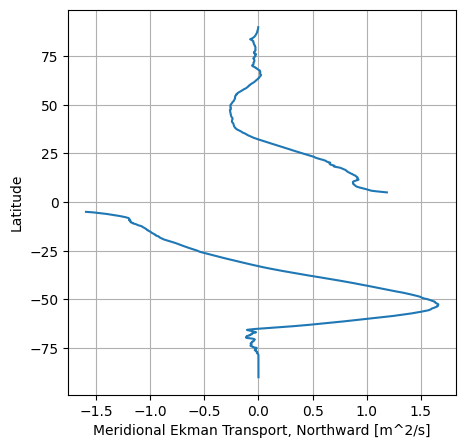

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.plot(M_y_mean, M_y_mean.lat, label='Meridional Ekman Transport')
plt.xlabel('Meridional Ekman Transport, Northward [m^2/s]')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

---
---

## Conclusion

$*$ (i.e. footnote from $\S1$ above):  `Dask` is easy 🤙, until things go wrong. 

Now continue on to Notebook 1 to learn to recognise & avoid these common pitfalls: `1_where_things_can_go_wrong.ipynb`